# Information about Trove's digitised journals

This notebook explores metadata created by a [harvest of digitised journals in Trove](Download-text-for-all-digitised-journals.ipynb). It downloads and analyses title and issue data saved as CSV files as part of the harvesting process.

In [125]:
import re
from io import BytesIO
import pandas as pd
import requests
from tqdm.auto import tqdm
import altair as alt

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Load the titles data

Summary information about digitised journals was [created by this notebook](Create-digitised-journals-list.ipynb). Additional information was added when [OCRd text was downloaded](Download-text-for-all-digitised-journals.ipynb) from each of the journals. Here we load the CSV file that was created by this process and see what we can find.

In [126]:
df = pd.read_csv('digital-journals-with-text.csv', dtype={'issues_with_text': 'int', 'issues': 'int'})

In [127]:
df.head()

,directory,fulltext_url,issues,issues_with_text,title,trove_id,trove_url
0,laws-etc-acts-of-the-parliament-nla.obj-54127737,http://nla.gov.au/nla.obj-54127737,15,15,"Laws, etc. (Acts of the Parliament)",nla.obj-54127737,https://trove.nla.gov.au/work/10078182
1,laws-etc-nla.obj-55312521,http://nla.gov.au/nla.obj-55312521,23,0,"Laws, etc",nla.obj-55312521,https://trove.nla.gov.au/work/10278751
2,parliamentary-papers-printed-during-the-nla.ob...,http://nla.gov.au/nla.obj-53867668,17,17,Parliamentary papers : printed during the ... ...,nla.obj-53867668,https://trove.nla.gov.au/work/10327501
3,the-order-of-service-for-the-annual-festival-t...,http://nla.gov.au/nla.obj-657473276,10,10,The Order of service for the annual festival t...,nla.obj-657473276,https://trove.nla.gov.au/work/10388163
4,journal-of-soil-conservation-new-south-wales-n...,http://nla.gov.au/nla.obj-740911077,183,183,"Journal of soil conservation, New South Wales",nla.obj-740911077,https://trove.nla.gov.au/work/10411388


How many journals have OCRd text?

In [128]:
df_text = df.loc[df['issues_with_text'] > 0]
df_text.shape

(383, 7)

How many journal issues have OCRd text?

In [129]:
df_text['issues_with_text'].sum()

30462

## Get data about all issues

Information about the issues available for each individual journal are available from a repository of the harvested journals on CloudStor. Here we download CSV files from each journal and combine them into one DataFrame.

In [130]:
# Public link to CloudStor repo
cloudstor_url = 'https://cloudstor.aarnet.edu.au/plus/s/QOmnqpGQCNCSC2h'
dfs = []

# Loop through the journal list
for journal in tqdm(df_text.itertuples(), total= df_text.shape[0]):
    
    # For each journal get the issues list from CloudStor and connvert to a dataframe
    j_issues = pd.read_csv('{}/download?path=%2F{}&files={}-issues.csv'.format(cloudstor_url, journal.directory, journal.trove_id), dtype={'pages': 'int'})
    
    # Add the dataframe to the list
    dfs.append(j_issues)

# Combine all the dataframes together
all_issues = pd.concat(dfs, ignore_index=True)

How many issues are there all together?

In [131]:
all_issues.shape

(31216, 5)

How many digitised pages are there for all issues of all journals?

In [132]:
all_issues['pages'].sum()

1472030

## Number of issues per year

The issue filenames include the basic publication details extracted from Trove. Usually this includes a publication date. We can try to extract a year from the filename and use it to visualise the number of issues published over time. Note that because of variations in the way the metadata is recorded, extracting a year isn't always successful, and sometimes a string of digits that looks like a year might be an issue number. It's not perfect, but it seems fairly effective.

In [133]:
def extract_year(details):
    '''
    Try to extract a year value from a file name.
    '''
    # Get all the things that look like years from the file name
    years = [int(y) for y in re.findall(r'\b((?:18|19|20){1}\d{2}\b)', str(details)) if int(y) <= 2019]
    
    # If we found some
    if years:
        
        # Take the last one -- this is because issue numbers generally seem to appear before dates.
        year = years[-1]
    else:
        
        # Nothing found, set to zero
        year = 0
    return year

# Apply the extract_year function to each row in the issues dataframe, saving the results to a new column
all_issues['year'] = all_issues['details'].apply(lambda x: extract_year(x))

In [134]:
# Have a peek at the results
all_issues.head()

,details,id,pages,text_file,title,year
0,Children's Court Act 1906,nla.obj-54127745,14,acts-of-the-parliament-passed-in-the-first-yea...,Acts of the Parliament : passed in the first y...,1906
1,Neglected Children's Act 1915,nla.obj-54127759,23,acts-of-the-parliament-passed-in-the-first-yea...,Acts of the Parliament : passed in the first y...,1915
2,Infant Life Protection Act 1915,nla.obj-54127768,13,acts-of-the-parliament-passed-in-the-first-yea...,Acts of the Parliament : passed in the first y...,1915
3,Children's Maintenance Act 1919,nla.obj-54127776,10,acts-of-the-parliament-passed-in-the-first-yea...,Acts of the Parliament : passed in the first y...,1919
4,Children's Welfare Act 1928,nla.obj-54127784,36,acts-of-the-parliament-passed-in-the-first-yea...,Acts of the Parliament : passed in the first y...,1928


Let's create a simple chart showing the number of issues over time.

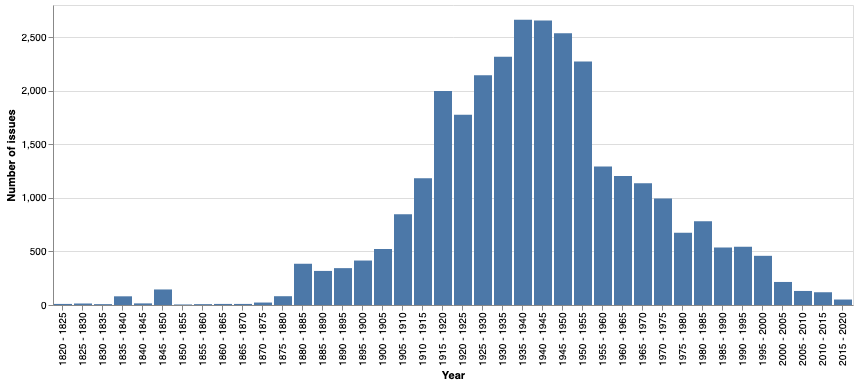

In [135]:
alt.Chart(all_issues.loc[all_issues['year'] > 0]).mark_bar().encode(
    
    # Year on the X axis -- bin the values to make it more readable
    x=alt.X('year:N',  bin=alt.Bin(maxbins=50), title='Year'),
    
    # Number of issues on the Y axis
    y=alt.Y('count():Q', title='Number of issues')
)